# Table Extraction

Table extraction is the process of detecting a table (**table detection**) and then recognizing its structure (**table structure recognition**). Here the document layout analysis is used for table detection, so we only have to perform table structure recognition. Camelot is chosen for this step as it is fast and performs reasonably well compared to SOTA on the TableBank dataset. Another package that can be used is tabula.  

We will use table extraction during the document layout analysis step to extract tables that are detected

In [3]:
#!pip3 install camelot-py
#!pip3 install tabula-py
#!pip3 install opencv-python
#!pip3 install pandas

In [4]:
import pandas as pd
import tabula

def extract_table_tabula(box, page, pdf):
    """ 
    Extract table with box in relative coordinates, page an integer and pdf a path to pdf.
    Note: Tabula box is (y1=top, x1=left, y2=bottom, x2=right) in IMAGE coordinate system !
    """
    print(pdf, page, box)
        
    # [top, left, bottom, right] is [y0, x0, y1, x1]
    box = (box[1]*100, box[0]*100 , box[3]*100, box[2]*100) 
    
    dfs = tabula.read_pdf(input_path = pdf, # path to pdf
                          output_format=None, # dataframe or json
                          encoding='utf-8', # pandas encoding in memory
                          java_options=None, # java vm options
                          pandas_options=None, # options related pandas package such as {'header': None}
                          multiple_tables=True, # more than one table
                          user_agent=None,
                          pages=page, # pages starting from 1 to analyze in pdf
                          guess=False, # table detection, set to false if an area is specified
                          area=box, # analyze(top,left,bottom,right). Default is entire page.
                          relative_area=True, # use relative area coordinates
                          lattice=False, # lattice algorithm uses cv to detect lines
                          stream=False, # stream uses relative positioning to detect columns and rows
                          password=None, # password encryption pdf
                          silent=None, # remove warning stderr
                          columns=None, # X coordinates of column boundaries such as [10.1, 20.2, 30.3]
                          format=None, # "CSV", "TSV", "JSON" output format
                          batch=None, # convert all pdfs in this directory
                          output_path=None, # path to write results in specified format
                          options='')
    df =  dfs[0] if dfs else pd.DataFrame()
    df.dropna(axis=1, how="all", inplace=True)
    df.dropna(axis=0, how="all", inplace=True)
    display(df)
    return df


# small test
box = [0.178, 0.40, 0.83, 0.73]
df = extract_table_tabula(box, '2', "../dataset/Alphabet_full.pdf")

../dataset/Alphabet_full.pdf 2 [0.178, 0.4, 0.83, 0.73]


,Unnamed: 0,2018 Alphabet Carbon Footprint (MT CO2e),Unnamed: 1
0,Scope 1,Location-based,Market-based
1,NaN,"63,521","63,521"
3,Scope 2,Location-based,Market-based
4,NaN,"4,344,686","684,236"
6,Subtotal Scope 1 + 2,"4,408,207","747,757"
8,Scope 3,Location-based,Market-based
9,NaN,"150,467","150,467"
11,NaN,"TOTAL FOOTPRINT 4,558,674","898,224"
13,Biogenic Emissions,Location-based,Market-based
14,NaN,"22,862","22,862"


In [5]:
import camelot
from camelot import utils

def extract_table_camelot(box, page, pdf):
    """ 
    Extract table with box in relative coordinates, page an integer and pdf a path to pdf.
    Note: table_areas should be ["x1=left,x2=top,x3=right,x4=bottom", ...] in PDF coordinat system !
    """
    print(pdf, page, box)
    
    layout, (w,h) = utils.get_page_layout(pdf)
    box = (box[0]*w, (1-box[1])*h, box[2]*w, (1-box[3])*h)
    box = [",".join([str(round(b,2)) for b in box])]
    
    page = str(page)
    
    dfs = camelot.read_pdf(filepath=pdf,
                           pages=page,
                           flavor='lattice', 
                           layout_kwargs = {}, # dict pdfminer.layout.LAParams
                           table_areas = box, 
                          )
    df = dfs[0].df if len(dfs)>0 else pd.DataFrame()
    df.dropna(axis=1, how="all", inplace=True)
    df.dropna(axis=0, how="all", inplace=True)
    display(df)
    return df


# Small test
box = [0.178, 0.40, 0.83, 0.73]
df = extract_table_camelot(box, '2', "../dataset/Alphabet_full.pdf")

../dataset/Alphabet_full.pdf 2 [0.178, 0.4, 0.83, 0.73]


,0,1,2,3
0,,,,
1,2018 Alphabet Carbon Footprint (MT CO2e),,,
2,Scope 1,Location-based,Market-based,
3,,"63,521","63,521",
4,,,,
5,Scope 2,Location-based,Market-based,
6,,"4,344,686","684,236",
7,,,,
8,Subtotal Scope 1 + 2,"4,408,207","747,757",
9,,,,


# Document Layout Analysis
Document layout analysis is used as a preprocessing step. It identifies test, lists, tables and figures, which can then be processed in an adapted way. In this case, tables are converted into a textual format and figures are ignored. Text and lists are extracted as is. This allows us to get a textual representation of a document that is more meaningful than just extracting the text without any context information.  

```dla(pdf, save_visual = False, disp = False)``` is the most important function here. It analyzes a pdf, saves a visual and outputs a dictionary of the extracted fields, which can then be dumped into a json file.



In [6]:
#!pip install tqdm
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#!pip install PyMuPDF
#!pip install tabula-py
#!pip install camelot
#!pip install torch
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
#!pip install torchvision
#!pip install pdf2image

## Object detection
Non-exhaustive history of object detection: finding objects in an image and classifying them:

1) **R-CNN**: region proposal using selective search algorithm -> alexnet for CNN features -> SVM classification   

2) **Fast R-CNN**: Selective search generates about 2000 region proposals. Running the through the network 2000 times is expensive. The idea is to just run computation once through alexnet, and share it. So move the selective search to after the CNN, because the cnn features are also a good input to the selective search for detecting bounding boxes. The problem is now that the output features don't have all the same size, so cannot be fed directly into a classifier. Use ROI pooling to resize all feature maps to the same size.  

3) **Faster R-CNN**: remove selective search, use RPN network with as input CNN features. CNN features are used for both RPN and classifier. Selective search was the bottleneck because it is an expensive algorithm and it is now removed. Yeay.  The RPN is a FCN (fully convolutional network = CNN where LL are replaced by their equivalent convolution) added on top of the CNN features that outputs proposed boxes and corresponding scores. The most promising bounding boxes are ran through the classifier.

4) **Mask R-CNN**: extending faster rcnn for pixel level segmentation. Add a FCN on top of CNN feature map that generates a mask. This runs in parallel of the RPN and classification.

5) **FPN**: Feature Pyramid Network: add a network on top of the CNN that does downsampling and upsampling using convolutions. In the upsampling part you predict ROI and Classes. This allows to look at multiple scales.

B) **Yolo**: use image to generate bounding boxes + confidence. Cut image into small squares and classify all the squares. Merge both informations to find bounding boxes that have a high classification threshold (a lot of squares to belong to the same class) and output them.

## Detectron

Detectron is a high quality, high performance code base for object detection research. It contains implementations of the following algorithms: Mask R-CNN, RetinaNet, Faster R-CNN, RPN, Fast R-CNN, R-FCN using the following backbone architectures: ResNet, ResNext, FPN (with Faster R-CNN) and VGG16.

It uses YAML configuration files containing all possible parameters of the implemented models. Thresholds can be modified but the network architecture parameters have to be the same as the pretrained network being used. An explanation of the different parameters can be foud [here](https://detectron2.readthedocs.io/en/latest/modules/config.html)

The pretrained models and training code can be found [here](https://github.com/hpanwar08/detectron2), facebook's detectron2 framework was used to train these models on the [publaynet](https://github.com/ibm-aur-nlp/PubLayNet) dataset.

Faster R-CNN detector with FPN backbone is a multi-scale detector that can detect big and small objects and has become the de-facto standard detector.

For this task, we use a *MaskRCNN Resnet101 FPN 3X* which is a Mask R-CNN with a 101 Resnet FPN 3x followed by a feature pyramid proposal network as backbone for a Mask R-CNN. 



**Todo:** Download *MaskRCNN Resnet101 FPN 3X* from [here](https://github.com/hpanwar08/detectron2) and put it into the models folder.

## Extract predictions



In [12]:
from numpy import asarray
from PIL import Image
from pdf2image import convert_from_path
import fitz # pyMuPdf library
import tabula
import json
import pandas as pd




def float_to_coordinate(rect, w, h):
    """ float to coordinate with some safety margin for text extraction """
    return [
        rect[0] * w - 5,
        rect[1] * h - 5,
        rect[2] * w + 5,
        rect[3] * h + 5
    ]


def extract_predictions(predictions, pdf, p):
    """ util function to extract words with the DLA information"""
    
    doc = fitz.open(pdf)
    page = doc[p-1] 
    fields = predictions["instances"].get_fields()
    height,width = predictions["instances"]._image_size
    res=[]
    for i in range(len(fields["pred_boxes"])):
        bb = fields["pred_boxes"].tensor[i]
        score = fields["scores"][i]
        pred_class = fields["pred_classes"][i]
        typ = MetadataCatalog.get("dla_val").thing_classes[pred_class]
        box = [bb[0].item()/width, bb[1].item()/height, 
               bb[2].item()/width, bb[3].item()/height]
        
        rect = fitz.Rect(float_to_coordinate(box, page.MediaBox.width, page.MediaBox.height))
        text = page.getTextbox(rect)

        field = {
            "type" : typ,
            "content": "---",
            "page" : p,
            "box": box,
            "score": score.item()
        }            
        
        if field["type"] == "figure":
                pass
        elif field["type"] == "table":
            table = extract_table_tabula(box,p, pdf)
            field["content"] = table.to_json()    
        elif field["type"] == "text":
            if len(text) > 50: 
                field["content"] = text                  
        elif field["type"] == "title":
            field["content"] = text
        elif field["type"] == "list":
            field["content"] = text
        else:
            pass
        res.append(field)
    return res

## Model Configuration
Below you can see the configurations node used by detectron. This default config file is updated by the .yaml config file that comes with the pretrained model. Only parameters linked to modules used by our model are of importance to us

In [13]:
from detectron2.config import get_cfg
print(get_cfg().MODEL.ROI_HEADS)
print()
print(get_cfg().MODEL.PANOPTIC_FPN)

BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES: ['res4']
IOU_LABELS: [0, 1]
IOU_THRESHOLDS: [0.5]
NAME: Res5ROIHeads
NMS_THRESH_TEST: 0.5
NUM_CLASSES: 80
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: True
SCORE_THRESH_TEST: 0.05

COMBINE:
  ENABLED: True
  INSTANCES_CONFIDENCE_THRESH: 0.5
  OVERLAP_THRESH: 0.5
  STUFF_AREA_LIMIT: 4096
INSTANCE_LOSS_WEIGHT: 1.0


## DLA

In [14]:
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg

def setup(roi_threshold = 0.5):
    
    # Config
    cfg = get_cfg()
    config_file = "model/DLA_mask_rcnn_R_101_FPN_3x.yaml"
    cfg.merge_from_file(config_file)
    opts = ["MODEL.WEIGHTS", "model/model_final_trimmed.pth", "MODEL.DEVICE" , "cuda:0" ]
    cfg.merge_from_list(opts)

    # Minimum score threshold (assuming scores in a [0, 1] range); a value chosen to
    # balance obtaining high recall with not having too many low precision
    # detections that will slow down inference post processing steps (like NMS)
    # A default threshold of 0.0 increases AP by ~0.2-0.3 but significantly slows down
    # inference. Remeber that AP is the area under the recall-precision curve.
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = roi_threshold

    # rename the classes to our specific use case
    from detectron2.data import MetadataCatalog
    MetadataCatalog.get("dla_val").thing_classes = ['text', 'title', 'list', 'table', 'figure']
    cfg.freeze()
    predictor = DefaultPredictor(cfg)
    return predictor


predictor = setup()

Config 'model/DLA_mask_rcnn_R_101_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [19]:
import cv2
import torch
import os
from detectron2.utils.visualizer import ColorMode, Visualizer


def save_images_as_pdf(images, path):
    im1 = images[0]
    im1.save(path,save_all=True, append_images=images[1:])


    
def save_dla(fields, images, name, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_images_as_pdf(images = images, path = output_dir + "/" + name + ".pdf")
    with open(output_dir + "/" + name + ".txt", 'w+') as f:
        json.dump(fields, f)



def run_on_image(image):
    vis_output = None
    predictions = predictor(image)
    # Convert image from OpenCV BGR format to Matplotlib RGB format.
    # image = image[:, :, ::-1]
    cfg = predictor.cfg
    metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused")
    instances = predictions["instances"].to(torch.device("cpu"))
    visualizer = Visualizer(image, metadata, instance_mode=ColorMode.IMAGE)
    vis_output = visualizer.draw_instance_predictions(predictions=instances)
    return predictions, vis_output


        
def predict(in_path):
    img = read_image(in_path, format="BGR")
    return predict_from_numpy(img)


    
def predict_from_numpy(in_numpy):
    predictions, visualized_output = run_on_image(in_numpy)
    return predictions, visualized_output



def extract_pdf(pdf):
    pages = convert_from_path(pdf)
    fields, images = [],[]
    for i,page in enumerate(pages):
        predictions, visualization = predict_from_numpy(asarray(page) )
        img = Image.fromarray(visualization.get_image())        
        fiel = extract_predictions(predictions, pdf, i+1)
        images.append(img)
        fields.extend(fiel)
    return fields, images


## Small Example

../dataset/Alphabet_one.pdf 1 [0.17913366315442678, 0.41450519406831177, 0.8229488202133086, 0.7008823820442764]


,Unnamed: 0,2018 Alphabet Carbon Footprint (MT CO2e),Unnamed: 1
0,Scope 1,Location-based,Market-based
1,NaN,"63,521","63,521"
3,Scope 2,Location-based,Market-based
4,NaN,"4,344,686","684,236"
6,Subtotal Scope 1 + 2,"4,408,207","747,757"
8,Scope 3,Location-based,Market-based
9,NaN,"150,467","150,467"
11,NaN,"TOTAL FOOTPRINT 4,558,674","898,224"
13,Biogenic Emissions,Location-based,Market-based
14,NaN,"22,862","22,862"


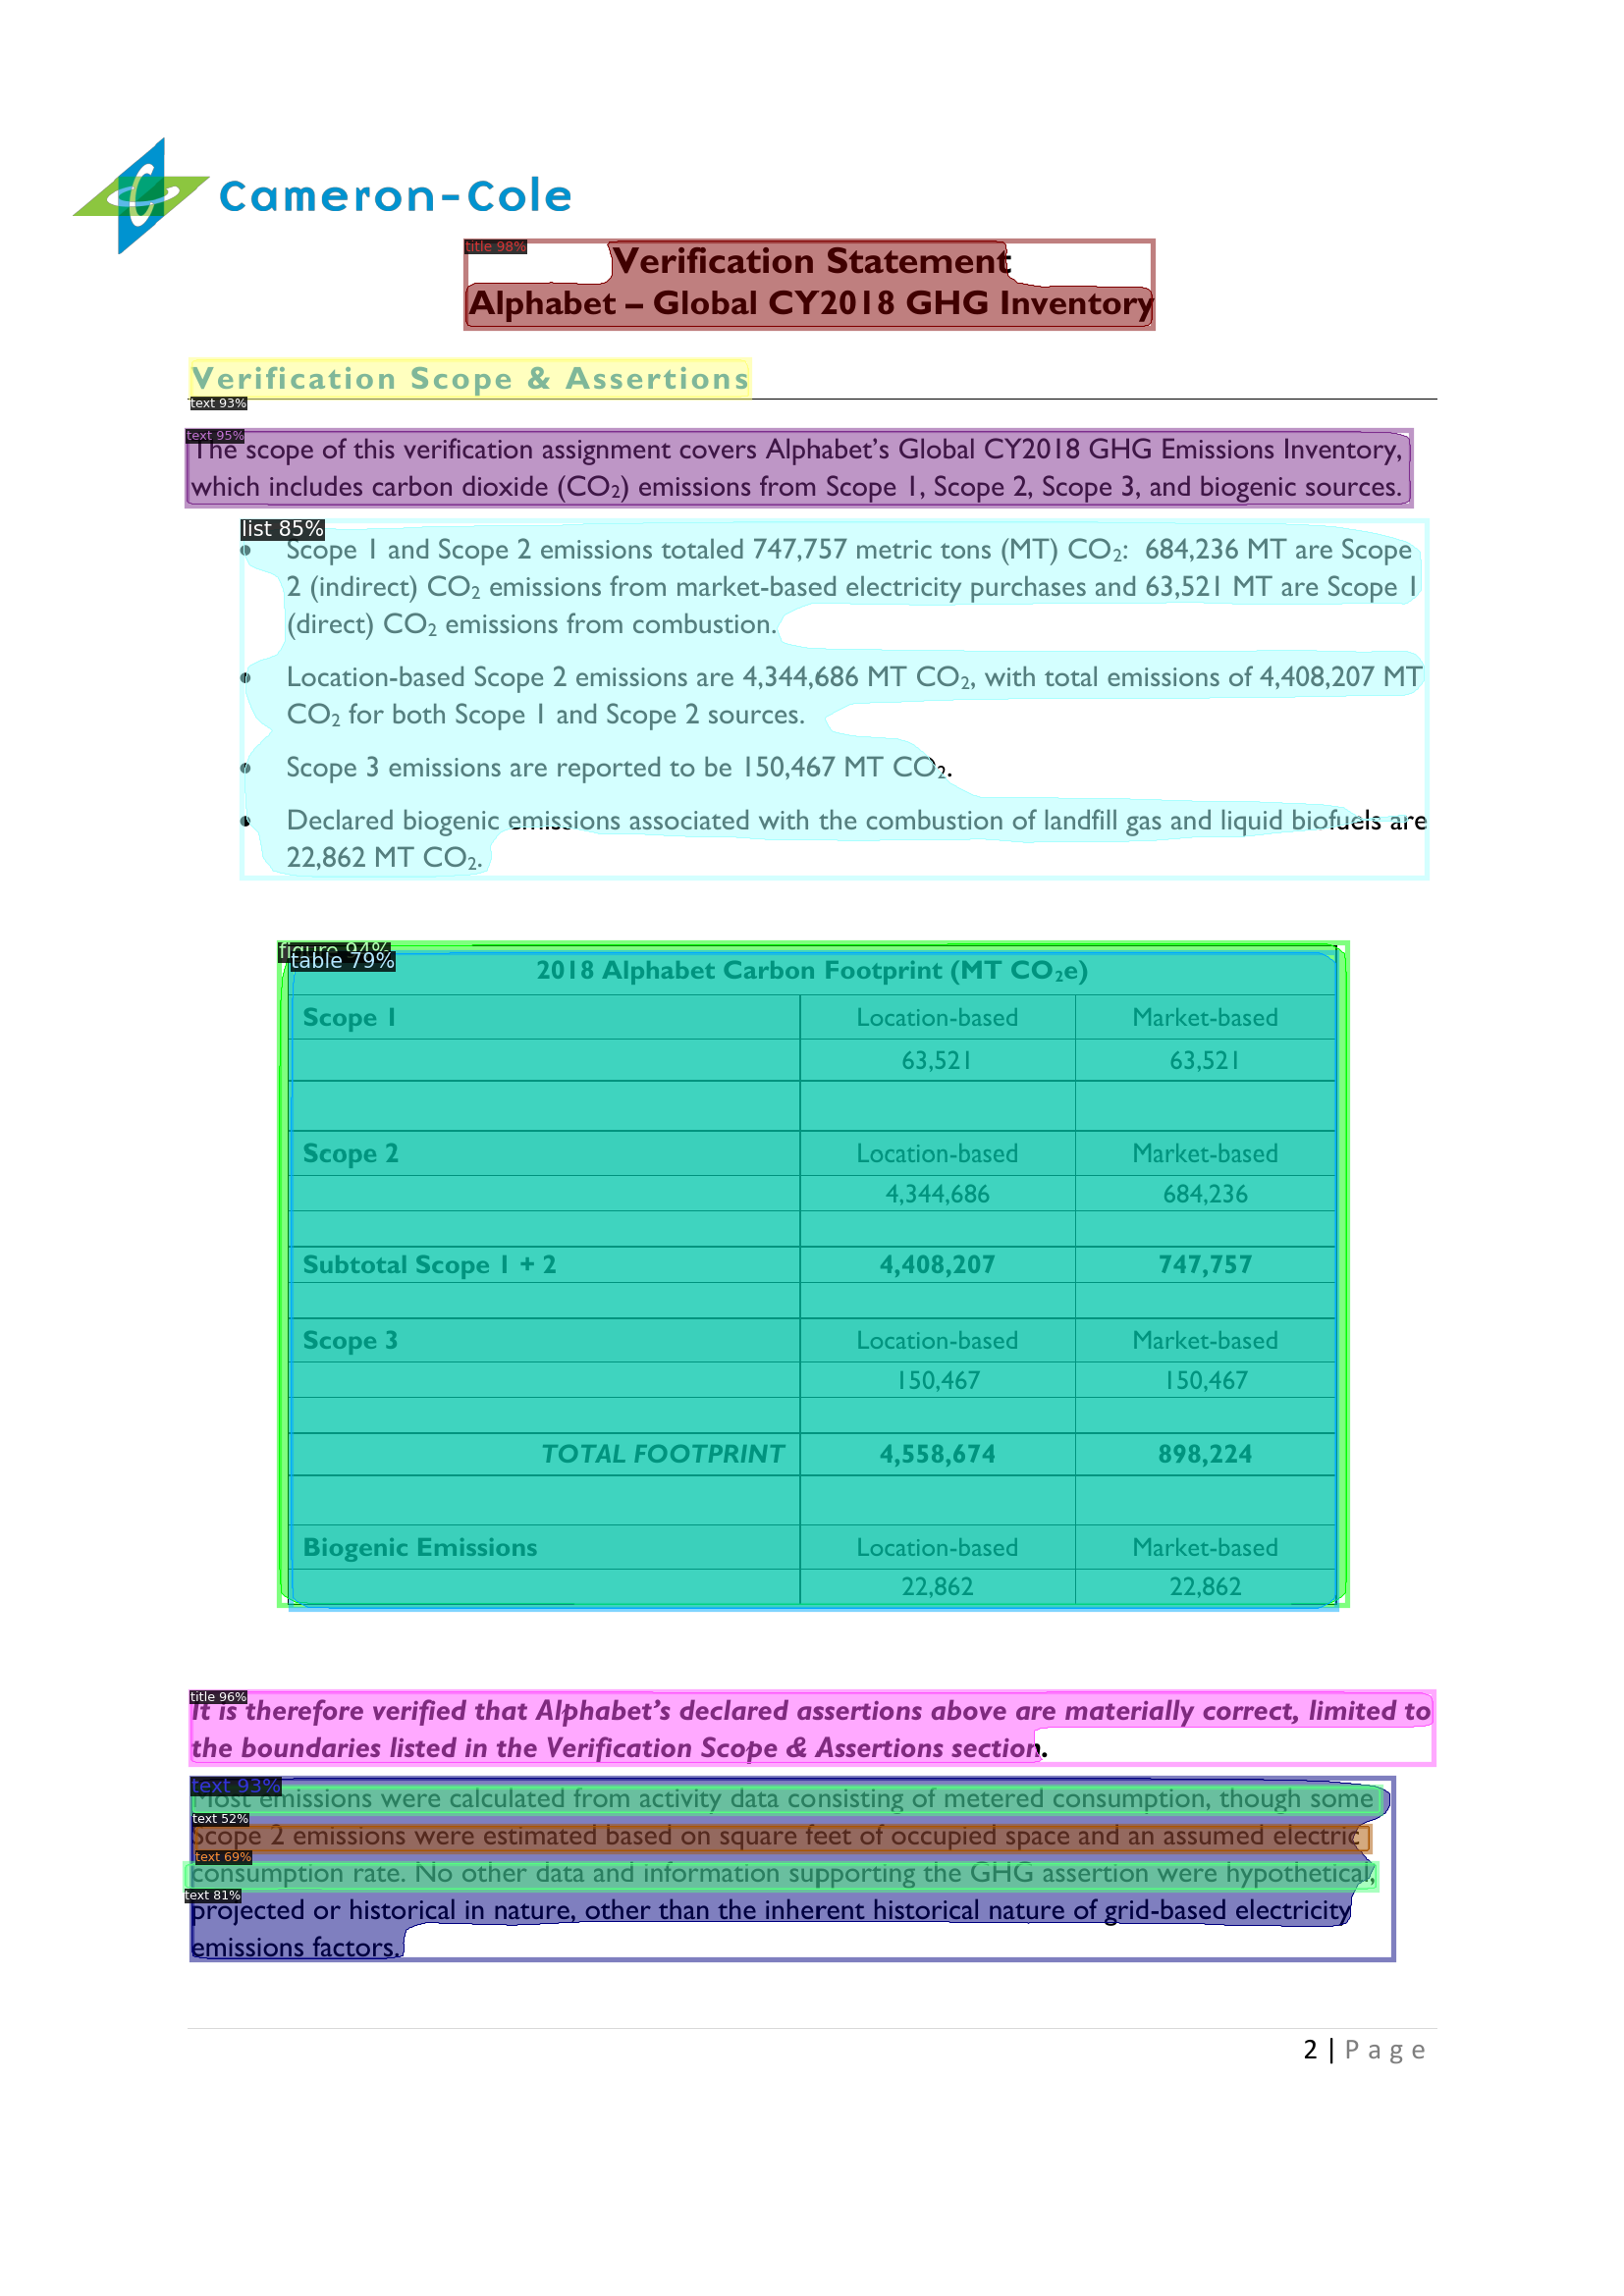

{'type': 'text', 'content': 'Most emissions were calculated from activity data consisting of metered consumption, though some ', 'page': 1, 'box': [0.1186773722232325, 0.7779900598546388, 0.8502189147284991, 0.7898543130744976], 'score': 0.5236755013465881}


In [20]:
from IPython.display import clear_output

pdf = "pdfs/Alphabet.pdf"
pages = convert_from_path(pdf)
fields, images = extract_pdf(pdf)
display(images[-1])
print(fields[-1])

## Analyze one pdf

In [11]:
pdf = "../dataset/Alphabet_one.pdf"    
fields, images = extract_pdf(pdf)
save_dla(fields = fields, images = images, name = pdf.split("/")[-1].replace(".pdf",""), output_dir = "test" )

../dataset/Alphabet_one.pdf 1 [0.17913366315442678, 0.41450519406831177, 0.8229488202133086, 0.7008823820442764]


,Unnamed: 0,2018 Alphabet Carbon Footprint (MT CO2e),Unnamed: 1
0,Scope 1,Location-based,Market-based
1,NaN,"63,521","63,521"
3,Scope 2,Location-based,Market-based
4,NaN,"4,344,686","684,236"
6,Subtotal Scope 1 + 2,"4,408,207","747,757"
8,Scope 3,Location-based,Market-based
9,NaN,"150,467","150,467"
11,NaN,"TOTAL FOOTPRINT 4,558,674","898,224"
13,Biogenic Emissions,Location-based,Market-based
14,NaN,"22,862","22,862"
